# Tanzanian Water Wells Status Prediction

By Melody Bass



![

## Introduction

Tanzania is a developing country that struggles to get clean water to its population of 59 million people.  The focus of this project is to build a classification model to predict the functionality of waterpoints in Tanzania given data provided by Taarifa and the Tanzanian Ministry of Water. The model was built from a dataset containing information about the source of water and status of the waterpoint (functional, functional but needs repairs, and non functional) using an iterative approach and can be found [here](./data/training_set_values.csv).  The dataset contains 60,000 waterpoints in Tanzania and the following features: 
* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
* `latitude` - GPS coordinate
* `wpt_name` - Name of the waterpoint if there is one
* `num_private` -
* `basin` - Geographic water basin
* `subvillage` - Geographic location
* `region` - Geographic location
* `region_code` - Geographic location (coded)
* `district_code` - Geographic location (coded)
* `lga` - Geographic location
* `ward` - Geographic location
* `population` - Population around the well
* `public_meeting` - True/False
* `recorded_by` - Group entering this row of data
* `scheme_management` - Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `construction_year` - Year the waterpoint was constructed
* `extraction_type` - The kind of extraction the waterpoint uses
* `extraction_type_group` - The kind of extraction the waterpoint uses
* `extraction_type_class` - The kind of extraction the waterpoint uses
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs
* `water_quality` - The quality of the water
* `quality_group` - The quality of the water
* `quantity` - The quantity of water
* `quantity_group` - The quantity of water
* `source` - The source of the water
* `source_type` - The source of the water
* `source_class` - The source of the water
* `waterpoint_type` - The kind of waterpoint
* `waterpoint_type_group` - The kind of waterpoint

The first sections focus on investigating, cleaning, wrangling, and reducing dimensionality for modeling.  The next section contains 6 different classification models and evaluation of each, ultimately leading to us to select our best model for predicting waterpoint status based on the accuracy of the model.  Finally, I will make recommendations to the Tanzanian Government and provide insight on predicting the status of waterpoints.

## Business Problem

Tanzania is a developing country that struggles to provide it's 59 million people with access to clean drinking water.  DrivenData has started a competition to help officials predict statuses of waterpoints by building a model to predict which pumps are functional, functional but need repair, and non functional.  The data is provided by Taarifa and the Tanzanian Ministry of Water with the hope that the information provided by each waterpoint can aid understanding in which waterpoints will fail to improve the government's maintenance operations and ensure that it's residents have access to safe drinking water. 

## Data Understanding

The dataset used for this analysis can be found [here](./data/training_set_values.csv).  It contains a wealth of information about waterpoints in Tanzania and the status of their operation.  The target variable has 3 different options for it's status:
* `functional` - the waterpoint is operational and there are no repairs needed
* `functional needs repair` - the waterpoint is operational, but needs repairs
* `non functional` - the waterpoint is not operational

Below I will import the dataset and start my investigation of relevant information it may contain.  Let's get started! 

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Scalers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize

# Categorical Create Dummies
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Data Import Train Set
df_train_set = pd.read_csv('data/training_set_values.csv', index_col='id')
df_train_set

amount_tsh date_recorded           funder  gps_height     installer  \
id                                                                           
69572      6000.0    2011-03-14            Roman        1390         Roman   
8776          0.0    2013-03-06          Grumeti        1399       GRUMETI   
34310        25.0    2013-02-25     Lottery Club         686  World vision   
67743         0.0    2013-01-28           Unicef         263        UNICEF   
19728         0.0    2011-07-13      Action In A           0       Artisan   
...           ...           ...              ...         ...           ...   
60739        10.0    2013-05-03  Germany Republi        1210           CES   
27263      4700.0    2011-05-07      Cefa-njombe        1212          Cefa   
37057         0.0    2011-04-11              NaN           0           NaN   
31282         0.0    2011-03-08            Malec           0          Musa   
26348         0.0    2011-03-23       World Bank         191         World   

       longitude   latitude              wpt_name  num_private  \
id                                                               
69572  34.938093  -9.856322                  none            0   
8776   34.698766  -2.147466              Zahanati            0   
34310  37.460664  -3.821329           Kwa Mahundi            0   
67743  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
19728  31.130847  -1.825359               Shuleni            0   
...          ...        ...                   ...          ...   
60739  37.169807  -3.253847   Area Three Namba 27            0   
27263  35.249991  -9.070629     Kwa Yahona Kuvala            0   
37057  34.017087  -8.750434               Mashine            0   
31282  35.861315  -6.378573                Mshoro            0   
26348  38.104048  -6.747464       Kwa Mzee Lugawa            0   

                         basin  ... payment_type water_quality  quality_group  \
id                              ...                                             
69572               Lake Nyasa  ...     annually          soft           good   
8776             Lake Victoria  ...    never pay          soft           good   
34310                  Pangani  ...   per bucket          soft           good   
67743  Ruvuma / Southern Coast  ...    never pay          soft           good   
19728            Lake Victoria  ...    never pay          soft           good   
...                        ...  ...          ...           ...            ...   
60739                  Pangani  ...   per bucket          soft           good   
27263                   Rufiji  ...     annually          soft           good   
37057                   Rufiji  ...      monthly      fluoride       fluoride   
31282                   Rufiji  ...    never pay          soft           good   
26348              Wami / Ruvu  ...   on failure         salty          salty   

           quantity quantity_group                source  \
id                                                         
69572        enough         enough                spring   
8776   insufficient   insufficient  rainwater harvesting   
34310        enough         enough                   dam   
67743           dry            dry           machine dbh   
19728      seasonal       seasonal  rainwater harvesting   
...             ...            ...                   ...   
60739        enough         enough                spring   
27263        enough         enough                 river   
37057        enough         enough           machine dbh   
31282  insufficient   insufficient          shallow well   
26348        enough         enough          shallow well   

                source_type source_class              waterpoint_type  \
id                                                                      
69572                spring  groundwater           communal standpipe   
8776   rainwater harvesting      surface           communal standpipe   
34310 

In [4]:
# Data import Training set labels
df_train_labels = pd.read_csv('data/training_set_labels.csv', index_col='id')
df_train_labels

status_group
id                   
69572      functional
8776       functional
34310      functional
67743  non functional
19728      functional
...               ...
60739      functional
27263      functional
37057      functional
31282      functional
26348      functional

[59400 rows x 1 columns]

In [5]:
#Merge datasets
df = pd.merge(df_train_labels, df_train_set, how = 'inner', on='id')

In [6]:
#Reset index
df.reset_index(inplace=True)
df.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.0    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional         0.0    2013-01-28        Unicef         263   
4  19728      functional         0.0    2011-07-13   Action In A           0   

      installer  longitude   latitude              wpt_name  ...  \
0         Roman  34.938093  -9.856322                  none  ...   
1       GRUMETI  34.698766  -2.147466              Zahanati  ...   
2  World vision  37.460664  -3.821329           Kwa Mahundi  ...   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu  ...   
4       Artisan  31.130847  -1.825359               Shuleni  ...   

   payment_type water_quality quality_group      quantity  quantity_group  \
0      annually          soft          good        enough          enough   
1     never pay          soft          good  insufficient    insufficient   
2    per bucket          soft          good        enough          enough   
3     never pay          soft          good           dry             dry   
4     never pay          soft          good      seasonal        seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 41 columns]

In [7]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [8]:
#Get stats on numeric columns
df.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [9]:
#Check for duplicates
sum(df.duplicated())

0

In [10]:
# Print all value counts to make observations
for col in df.columns:
    print(df[col].value_counts())

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-08-30      1
2012-01-21      1
2004-01-07      1
2013-01-01      1
2011-09-05      1
Name: date_recorded, Length: 356, dtype: int64
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Noshadi                      1
Kolopi

In [11]:
# Check null values
df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [12]:
# Check unique values for categorical data
obj_df = df.select_dtypes(include=['object'])
obj_df.nunique()

status_group                 3
date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

### Initial Observations

#### Missing Values

__scheme_name__ has the most missing values, followed by __funder__, __installer__,  __public_meeting__, __scheme_management__,  and __permit__ with ~3,000 null values, and then __subvillage__ with 371 null values.  Several of these columns will be deleted as they appear to duplicate other columns, and I will investigate __installer__, __permit__, and __subvillage__ further.

#### Data types

* __wpt_name__, __subvillage__, __ward__, __scheme_name__, __installer__, __funder__, and __date_recorded__ are categorical features that have unique values in the thousands.  This will be a problem with dummy variables, will likely remove or feature engineer. 
* I will drop __recorded_by__ as it has the same value for all rows.
* __num_private__ is not defined on the DrivenData site, and it is not obvious what the feature indicates. 
* __id__ column will be dropped.
* __public_meeting__ and __permit__ are boolean.
* __construction_year__, __latitude__, __longitude__, __gps_height, __amount_tsh__, and __population__ all have thousands of rows of 0 entered.  I will drop rows for most of these variables that have 0 entered, and will have to investigate further for real data on some columns.  
 
#### Duplicate  and Similar Data
 
The following columns all contain duplicate or similar data, will remove features that will cause multicollinearity:
* __extraction_type__, __extraction_type_group__, and __extraction_type_class__
* __payment__ and __payment_type__
* __water_quality__ and __quality_group__ 
* __quanitity__ and __quantity_group__
* __source__ and __source_type__
* __waterpoint_type__ and __waterpoint_type_group__
* __region__ and __region_code__

## Data Cleaning

In this section, I will clean the dataset by removing similar and unnecessary columns and trim the dataset of remaining null values.  I will also further investigate whether some columns contain the same information if it was not immediately obvious.  There are several rows containing 0 enteries in some column information.  I will investigate whether I believe the data to be real instead of a placeholder.

### Drop duplicate and columns with similar information

I will keep __extraction_type_class__ and remove __extraction_type__ and __extraction_type_group__ as it's columns values appear to be the most relevant for the project. __scheme_name__ will be dropped for it's many null values.  Other columns will be removed at this point due to irrelavancy, duplicates, null values, and some others will have to be investigated after the first drop.

In [13]:
# Columns to be dropped
dropped_columns = ['extraction_type', 'extraction_type_group', 'payment', 'scheme_name', 'quality_group',
                   'quantity_group', 'source', 'waterpoint_type_group', 'recorded_by', 'num_private', 'id', 'subvillage',
                  'wpt_name', 'ward', 'funder', 'date_recorded', 'public_meeting', 'region_code', 'district_code', 'lga',
                  'scheme_management', 'source_class']

In [14]:
df = df.drop(dropped_columns, axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   population             59400 non-null  int64  
 9   permit                 56344 non-null  object 
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  management_group       59400 non-null  object 
 14  payment_type           59400 non-null  object 
 15  wa

### Dealing with null values

In [16]:
#Check for nulls
df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region                      0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [17]:
# Drop all remaining null values from our dataset
df = df.dropna()

In [18]:
#Check to see that it worked
df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type          0
dtype: int64

In [19]:
# Convert boolean permit to integers
df['permit'] = df['permit'].astype(int)

In [20]:
# Check to see that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55102 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           55102 non-null  object 
 1   amount_tsh             55102 non-null  float64
 2   gps_height             55102 non-null  int64  
 3   installer              55102 non-null  object 
 4   longitude              55102 non-null  float64
 5   latitude               55102 non-null  float64
 6   basin                  55102 non-null  object 
 7   region                 55102 non-null  object 
 8   population             55102 non-null  int64  
 9   permit                 55102 non-null  int64  
 10  construction_year      55102 non-null  int64  
 11  extraction_type_class  55102 non-null  object 
 12  management             55102 non-null  object 
 13  management_group       55102 non-null  object 
 14  payment_type           55102 non-null  object 
 15  wa

### Investigate management and management_group

I need to investigate these 2 columns further to see if they contain similar information.

In [21]:
df['management'].value_counts()

vwc                 37416
wug                  6314
water board          2705
wua                  2307
private operator     1891
parastatal           1588
water authority       825
other                 733
company               656
unknown               491
other - school         99
trust                  77
Name: management, dtype: int64

In [22]:
df['management_group'].value_counts()

user-group    48742
commercial     3449
parastatal     1588
other           832
unknown         491
Name: management_group, dtype: int64

The most data is contained in the user-group subcategory of __management_group__.  I will groupby to investigate if the information is similar.

In [23]:
df.loc[df['management_group']=='user-group']['management'].value_counts()

vwc            37416
wug             6314
water board     2705
wua             2307
Name: management, dtype: int64

The data is identical to the data contained in the management column in the subcategory of 'user-group'.  I will drop __management_group__ from our features.

In [24]:
#Drop column
df = df.drop('management_group', axis=1)

In [25]:
#Check to see that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55102 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           55102 non-null  object 
 1   amount_tsh             55102 non-null  float64
 2   gps_height             55102 non-null  int64  
 3   installer              55102 non-null  object 
 4   longitude              55102 non-null  float64
 5   latitude               55102 non-null  float64
 6   basin                  55102 non-null  object 
 7   region                 55102 non-null  object 
 8   population             55102 non-null  int64  
 9   permit                 55102 non-null  int64  
 10  construction_year      55102 non-null  int64  
 11  extraction_type_class  55102 non-null  object 
 12  management             55102 non-null  object 
 13  payment_type           55102 non-null  object 
 14  water_quality          55102 non-null  object 
 15  qu

In [26]:
for col in df.columns:
    print(df[col].value_counts())

functional                 29885
non functional             21381
functional needs repair     3836
Name: status_group, dtype: int64
0.0        37811
500.0       3071
50.0        2333
1000.0      1442
20.0        1427
           ...  
38000.0        1
1400.0         1
8500.0         1
6300.0         1
26.0           1
Name: amount_tsh, Length: 95, dtype: int64
 0       18310
-15         54
 303        51
-16         51
-13         50
         ...  
 2424        1
 2405        1
 2628        1
 2552        1
 2576        1
Name: gps_height, Length: 2426, dtype: int64
DWE             17361
Government       1788
RWE              1203
Commu            1060
DANIDA           1049
                ...  
PIUS CHARLES        1
Winkyens            1
Carmatech           1
inkinda             1
College             1
Name: installer, Length: 2056, dtype: int64
0.000000     1793
32.984790       2
37.540901       2
37.328905       2
37.252194       2
             ... 
39.002868       1
37.095964       

After our first round of cleaning, there are several features we need to examine further:
* __status_group__ is an unbalanced target, may need to look into further during modeling and apply SMOTE.
* There are several columns with thousands of 0 entries - __amount_tsh__, __gps_height__, __longitude__, __latitude__, __population__, __construction_year__.

### Construction year

In [27]:
df['construction_year'].value_counts()

0       18392
2008     2568
2009     2490
2010     2427
2000     1565
2007     1557
2006     1447
2003     1276
2011     1211
2004     1107
2002     1064
1978     1027
2012     1025
2005      983
1995      978
1999      950
1985      941
1998      921
1984      777
1996      766
1982      741
1972      705
1994      703
1974      675
1990      666
1980      647
1992      632
1997      612
1993      595
2001      530
1988      520
1983      487
1975      437
1986      431
1976      411
1991      322
1989      316
1970      310
1987      297
1981      237
1977      199
1979      192
1973      183
2013      173
1971      145
1963       84
1967       83
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [28]:
# Finding mean and median without zero values
df.loc[df['construction_year']!=0].describe()

amount_tsh    gps_height     longitude      latitude    population  \
count   36710.000000  36710.000000  36710.000000  36710.000000  36710.000000   
mean      471.881843    982.395015     36.015003     -6.358975    268.881694   
std      3074.841656    623.784917      2.609370      2.762486    542.812926   
min         0.000000    -63.000000     29.607122    -11.649440      0.000000   
25%         0.000000    351.000000     34.671850     -8.855908     30.000000   
50%         0.000000   1116.500000     36.691907     -6.351197    150.000000   
75%       200.000000   1471.000000     37.896261     -3.731978    304.000000   
max    250000.000000   2770.000000     40.345193     -1.042375  30500.000000   

             permit  construction_year  
count  36710.000000       36710.000000  
mean       0.717379        1996.888096  
std        0.450280          12.452883  
min        0.000000        1960.000000  
25%        0.000000        1987.000000  
50%        1.000000        2000.000000  
75%        1.000000        2008.000000  
max        1.000000        2013.000000

In [29]:
#Replace 0 values in construction_year with mean of data without 0s.
df['construction_year'].replace(to_replace = 0, value = 1996, inplace=True)

In [30]:
#Check to see if it worked
df['construction_year'].value_counts()

1996    19158
2008     2568
2009     2490
2010     2427
2000     1565
2007     1557
2006     1447
2003     1276
2011     1211
2004     1107
2002     1064
1978     1027
2012     1025
2005      983
1995      978
1999      950
1985      941
1998      921
1984      777
1982      741
1972      705
1994      703
1974      675
1990      666
1980      647
1992      632
1997      612
1993      595
2001      530
1988      520
1983      487
1975      437
1986      431
1976      411
1991      322
1989      316
1970      310
1987      297
1981      237
1977      199
1979      192
1973      183
2013      173
1971      145
1963       84
1967       83
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

It is unfortunate that there are 19,000 entries with 0 for the __construction_year__.  I chose to replace the 0 values with 1996, the mean of the dataset, since it was such a large representation of the dataset.

### Latitude/Longitude zeros

In [31]:
df.longitude.value_counts()

0.000000     1793
32.984790       2
37.540901       2
37.328905       2
37.252194       2
             ... 
39.002868       1
37.095964       1
36.658462       1
33.116994       1
38.592731       1
Name: longitude, Length: 53261, dtype: int64

In [32]:
# Investigate longitude entries that are 0
df.loc[df['longitude'] == 0]

status_group  amount_tsh  gps_height     installer  \
21                  functional         0.0           0           DWE   
53              non functional         0.0           0    Government   
168                 functional         0.0           0           WVT   
177             non functional         0.0           0           DWE   
253    functional needs repair         0.0           0           DWE   
...                        ...         ...         ...           ...   
59189  functional needs repair         0.0           0           DWE   
59208               functional         0.0           0           DWE   
59295  functional needs repair         0.0           0           DWE   
59324               functional         0.0           0  World Vision   
59374               functional         0.0           0           DWE   

       longitude      latitude          basin     region  population  permit  \
21           0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
53           0.0 -2.000000e-08  Lake Victoria     Mwanza           0       1   
168          0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
177          0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
253          0.0 -2.000000e-08  Lake Victoria     Mwanza           0       1   
...          ...           ...            ...        ...         ...     ...   
59189        0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
59208        0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
59295        0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
59324        0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   
59374        0.0 -2.000000e-08  Lake Victoria  Shinyanga           0       0   

       construction_year extraction_type_class  management payment_type  \
21                  1996              handpump         wug      unknown   
53                  1996           submersible         vwc      unknown   
168                 1996               gravity  parastatal        other   
177                 1996                 other         wug      unknown   
253                 1996              handpump         vwc    never pay   
...                  ...                   ...         ...          ...   
59189               1996              handpump         wug        other   
59208               1996              handpump         wug      unknown   
59295               1996              handpump         wug    never pay   
59324               1996              handpump         wug      unknown   
59374               1996              handpump         wug        other   

      water_quality      quantity           source_type  \
21          unknown       unknown          shallow well   
53          unknown           dry              borehole   
168            soft      seasonal  rainwater harvesting   
177            soft        enough          shallow well   
253            soft  insufficient          shallow well   
...             ...           ...                   ...   
59189          soft        enough          shallow well   
59208          soft        enough          shallow well   
59295          soft        enough          shallow well   
59324          soft        enough          shallow well   
59374          soft        enough          shallow well   

                   waterpoint_type  
21                       hand pump  
53     communal standpipe multiple  
168             communal standpipe  
177                          other  
253                      hand pump  
...                            ...  
59189                    hand pump  
59208                    hand pump  
59295                    hand pump  
59324                    hand pump  
59374                    hand pump  

[1793 rows x 18 columns]

The 0s that are entered into the longitude column are also 0s in gps_height and -2e8 for latitude columns.  I will drop these values from the dataset.

In [33]:
# Drop rows with 0 entered in longitude column
df = df.loc[df['longitude'] != 0]

In [34]:
# Check to see if it worked
df.describe()

amount_tsh    gps_height     longitude      latitude    population  \
count   53309.000000  53309.000000  53309.000000  53309.000000  53309.000000   
mean      337.580181    692.509670     35.186804     -5.849440    188.814515   
std      2714.547122    691.264883      2.670974      2.806529    474.147131   
min         0.000000    -90.000000     29.607122    -11.649440      0.000000   
25%         0.000000      0.000000     33.167340     -8.441371      0.000000   
50%         0.000000    438.000000     35.295878     -5.144420     45.000000   
75%        40.000000   1322.000000     37.353028     -3.359390    240.000000   
max    250000.000000   2770.000000     40.345193     -0.998464  30500.000000   

             permit  construction_year  
count  53309.000000       53309.000000  
mean       0.702508        1996.611567  
std        0.457159          10.341978  
min        0.000000        1960.000000  
25%        0.000000        1995.000000  
50%        1.000000        1996.000000  
75%        1.000000        2005.000000  
max        1.000000        2013.000000

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53309 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           53309 non-null  object 
 1   amount_tsh             53309 non-null  float64
 2   gps_height             53309 non-null  int64  
 3   installer              53309 non-null  object 
 4   longitude              53309 non-null  float64
 5   latitude               53309 non-null  float64
 6   basin                  53309 non-null  object 
 7   region                 53309 non-null  object 
 8   population             53309 non-null  int64  
 9   permit                 53309 non-null  int64  
 10  construction_year      53309 non-null  int64  
 11  extraction_type_class  53309 non-null  object 
 12  management             53309 non-null  object 
 13  payment_type           53309 non-null  object 
 14  water_quality          53309 non-null  object 
 15  qu

Looks like it all worked!  I believe the __amount_tsh__ and __population__ 0 values are real so I will leave all data as is for vanilla models.

### Installer - Several different spellings for same installer

In [36]:
#Check unique values after inital cleaning
df.nunique()

status_group                 3
amount_tsh                  95
gps_height                2426
installer                 2024
longitude                53260
latitude                 53262
basin                        9
region                      21
population                1026
permit                       2
construction_year           54
extraction_type_class        7
management                  12
payment_type                 7
water_quality                8
quantity                     5
source_type                  7
waterpoint_type              7
dtype: int64

Upon checking the unique values for our categorical variables after trimming the dataset, installer still has 2024 unique entries, which will be a problem when we create dummies.  We will need to cut down the amount of unique entries to not overload our model.

In [37]:
#Investigate 2024 unique values for installer
# pd.set_option("display.max_rows", None)
df['installer'].value_counts()

DWE                     16214
Government               1633
RWE                      1178
Commu                    1060
DANIDA                   1049
                        ...  
MP Mloka                    1
Lion's                      1
Pori la akiba kigosi        1
local                       1
IN                          1
Name: installer, Length: 2024, dtype: int64

There are several entries with typos and different variations of the same installer. I will attempt to fix some of the clerical errors and narrow down the amount of unique identifiers we will use for our model.

In [38]:
# Correct variations and misspellings in the installer column
df['installer'] = df['installer'].replace(to_replace = ('Central government', 'Tanzania Government',
                                          'Cental Government','Tanzania government','Cebtral Government', 
                                          'Centra Government', 'central government', 'CENTRAL GOVERNMENT', 
                                          'TANZANIA GOVERNMENT','Central govt', 'Centr', 'Centra govt', 
                                          'Tanzanian Government', 'Tanzania'), value = 'Central Government')

df['installer'] = df['installer'].replace(to_replace = ('District COUNCIL', 'DISTRICT COUNCIL',
                                          'Counc','District council','District Counci', 
                                          'Council', 'COUN', 'Distri', 'District  Council'), 
                                          value = 'District Council')

df['installer'] = df['installer'].replace(to_replace = ('villigers', 'villager', 'villagers', 'Villa', 'Village',
                                          'Villi', 'Village Council', 'Village Counil', 'Villages', 'Vill', 
                                          'Village community', 'Villaers', 'Village Community', 'Villag',
                                          'Villege Council', 'Village council', 'Village Council', 'Villagerd', 
                                          'Villager', 'Village Technician', 'Village Office', 'VILLAGE COUNCIL',
                                          'Village community members', 'VILLAG', 'Village Government', 
                                          'Village govt', 'VILLAGERS', 'Village  Council'), value ='Villagers')

df['installer'] = df['installer'].replace(to_replace = ('District Water Department', 'District water depar',
                                          'Distric Water Department'), value ='District water department')

df['installer'] = df['installer'].replace(to_replace = ('FinW', 'Fini water', 'FINI WATER', 'FIN WATER',
                                          'Finwater', 'FINN WATER', 'FinW', 'FW', 'FinWater', 'FiNI WATER'), 
                                          value ='Fini Water')

df['installer'] = df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC', 'RC Ch', 'RC C', 'RC CH',
                                          'RC church', 'RC CATHORIC', 'Ch') , value ='RC Church')

df['installer'] = df['installer'].replace(to_replace = ('world vision', 'World Division', 'World vision', 
                                          'WORLD VISION', 'World Vission'), value ='World Vision')

df['installer'] = df['installer'].replace(to_replace = ('Unisef','Unicef'), value ='UNICEF')

df['installer'] = df['installer'].replace(to_replace = 'DANID', value ='DANIDA')

df['installer'] = df['installer'].replace(to_replace =('Commu', 'Communit', 'commu', 'COMMU', 'COMMUNITY', 
                                          'Adra /Community', 'Communit', 'Adra/Community', 'Adra/ Community'), 
                                          value ='Community')

df['installer'] = df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM', 'GOVERN',
                                          'Gover', 'Gove', 'Governme', 'Governmen'), value ='Government')

df['installer'] = df['installer'].replace(to_replace = ('Hesawa', 'hesawa'), value ='HESAWA')

df['installer'] = df['installer'].replace(to_replace = ('JAICA', 'JICA', 'Jica', 'Jeica', 'JAICA CO'), 
                                          value ='Jaica')

df['installer'] = df['installer'].replace(to_replace = ('KKKT _ Konde and DWE', 'KKT', 'KKKT Church', 'KkKT'), 
                                          value ='KKKT')

df['installer'] = df['installer'].replace(to_replace = '0', value ='Unknown')

In [39]:
df['installer'].value_counts().head(20)

DWE                   16214
Government             2468
Community              1791
DANIDA                 1601
HESAWA                 1180
RWE                    1178
District Council       1173
Central Government     1115
KKKT                   1102
Fini Water              952
Unknown                 780
TCRS                    702
World Vision            660
CES                     610
RC Church               484
Villagers               482
LGA                     408
WEDECO                  397
TASAF                   371
Jaica                   358
Name: installer, dtype: int64

### Reduce dimensionality for installer

In [41]:
# Keep only top 20 installers as unique values
installer_20 = df.installer.value_counts(normalize=True).head(20).index.tolist()  


df['installer'] = [type_ if type_ in installer_20
                      else "OTHER" for type_ in df['installer']]

In [66]:
df.installer.value_counts()

OTHER                 19283
DWE                   16214
Government             2468
Community              1791
DANIDA                 1601
HESAWA                 1180
RWE                    1178
District Council       1173
Central Government     1115
KKKT                   1102
Fini Water              952
Unknown                 780
TCRS                    702
World Vision            660
CES                     610
RC Church               484
Villagers               482
LGA                     408
WEDECO                  397
TASAF                   371
Jaica                   358
Name: installer, dtype: int64

To reduce the dimensionality of the dataset, I made an "Other" category for installer if they were not in the top 20 installers of the dataset.

## Modified Features Exploration

### Column EDA

#### Construction year

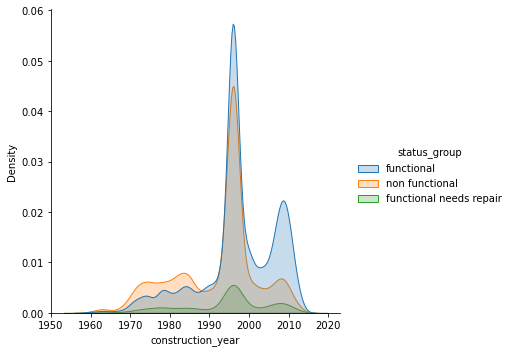

In [43]:
sns.displot(data=installer_df, x='construction_year', hue='status_group', kind='kde', fill=True);

There is not a lot of separation between status of pump and the year it was constructed.  We can also see the large amount of data in the year 1996.

#### Population

In [102]:
sns.displot(data=df, x='population', hue='status_group', kind='kde', normalize=True, fill=True);

ValueError: Could not interpret value `status_group` for parameter `hue`

#### Extraction_type_class

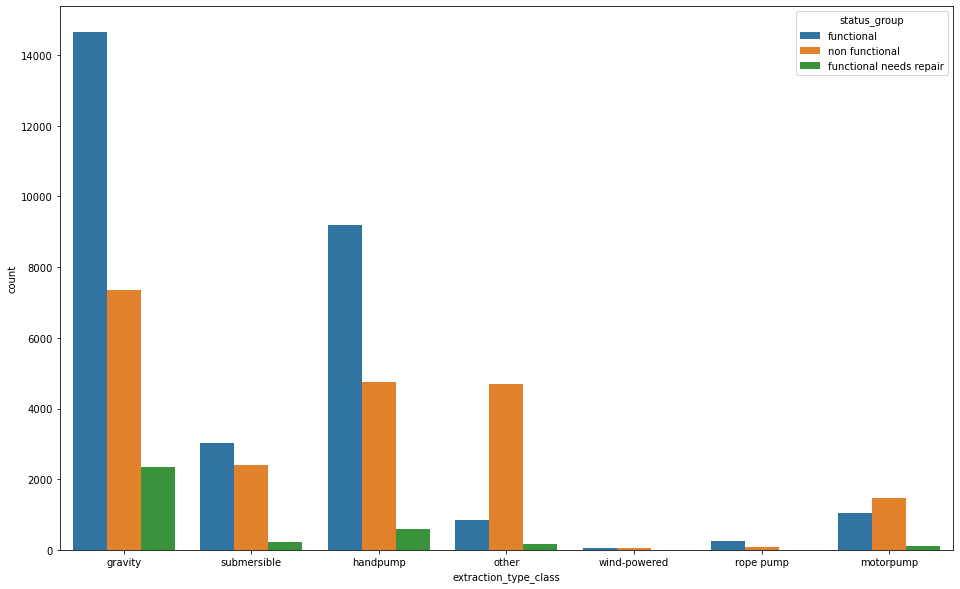

In [49]:
plt.figure(figsize=(16,10))
ax = sns.countplot(x='extraction_type_class', hue='status_group', data=df);


Other type and motorpump are especially non functioning.  Gravity and handpump are the 2 largest types, and both have more functioning, but half non functioning.

#### Management

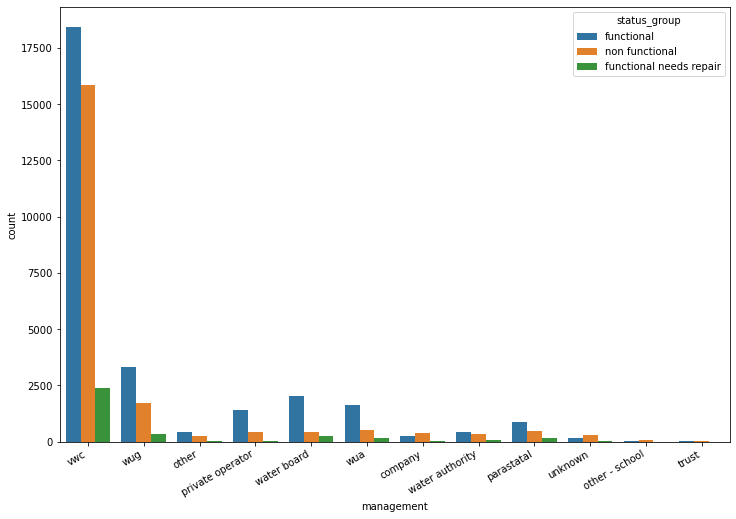

In [54]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='management', hue='status_group', data=df)
plt.xticks(rotation=30, ha='right');

#### Payment_type

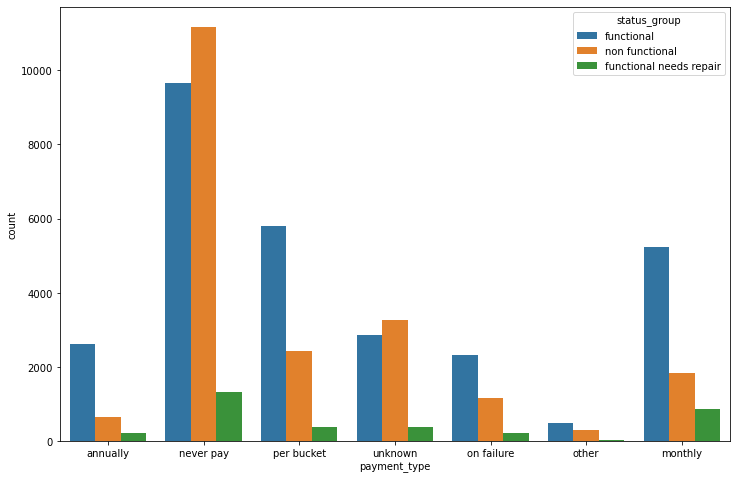

In [46]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='payment_type', hue='status_group', data=df)

Never pay pumps have more non functioning waterpoints than functioning waterpoints. 

#### Water quality

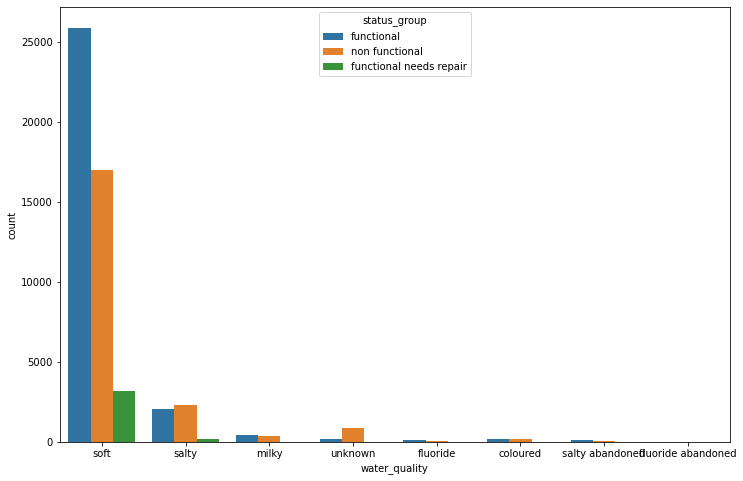

In [47]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='water_quality', hue='status_group', data=df)

Soft water quality has a high rate of functional waterpoints, salty has a high rate of non functional waterpoints.

#### Source type

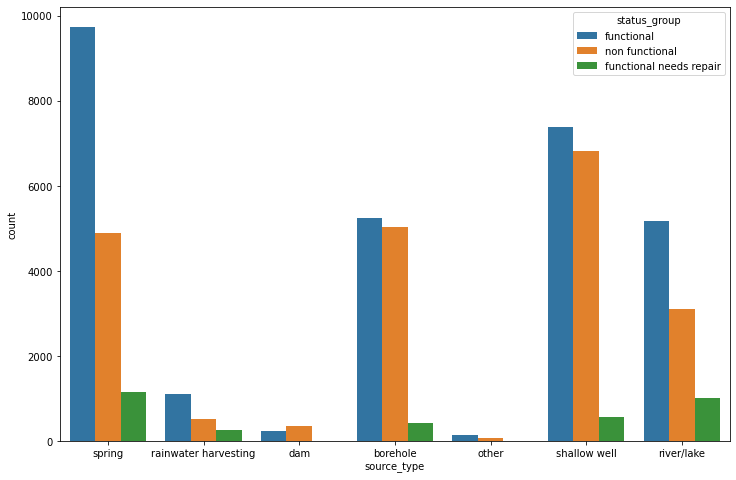

In [48]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='source_type', hue='status_group', data=df)

#### Basin

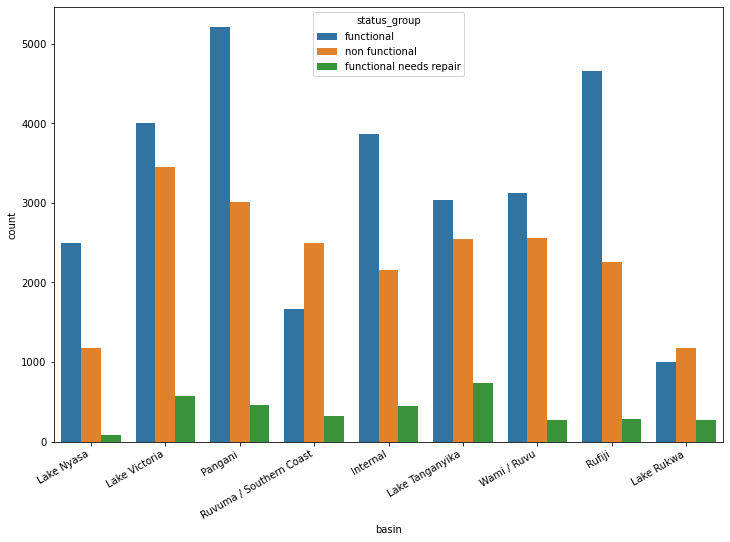

In [55]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='basin', hue='status_group', data=df)
plt.xticks(rotation=30, ha='right');

The Ruvuma/Southern Coast and Lake Rukwa basins have more non functioning wells than functional.  

#### Quantity

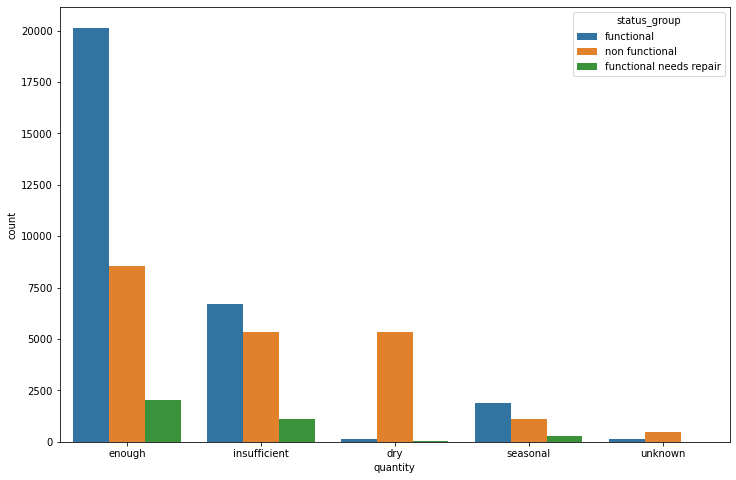

In [56]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='quantity', hue="status_group", data=df)
plt.save_fig('./images/quantity_function.png');

Dry waterpoints have a high chance of being non functional, as expected.  If the waterpoint has enough water, there is a high chance of functionality.

#### Region

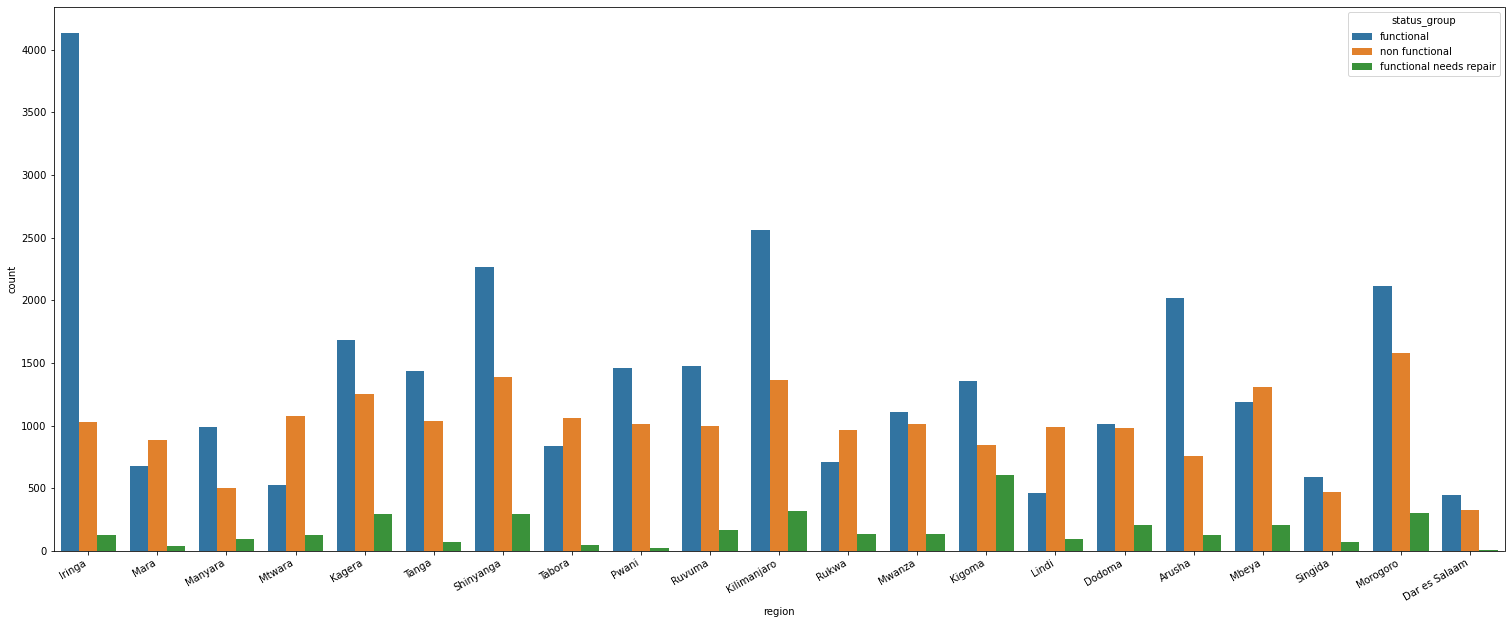

In [63]:
plt.figure(figsize=(26,10))
ax = sns.countplot(x='region', hue="status_group", data=df)
plt.xticks(rotation=30, ha='right')
plt.save_fig('./images/region_function.png');

The Iringa region has a very high rate of functioning wells, followed by Kilimanjaro, Arusha, and Shinyanga.  The worst regions for well perfomance are Mtwara, Mara, Rukwa,  and Lindi.

#### Waterpoint type

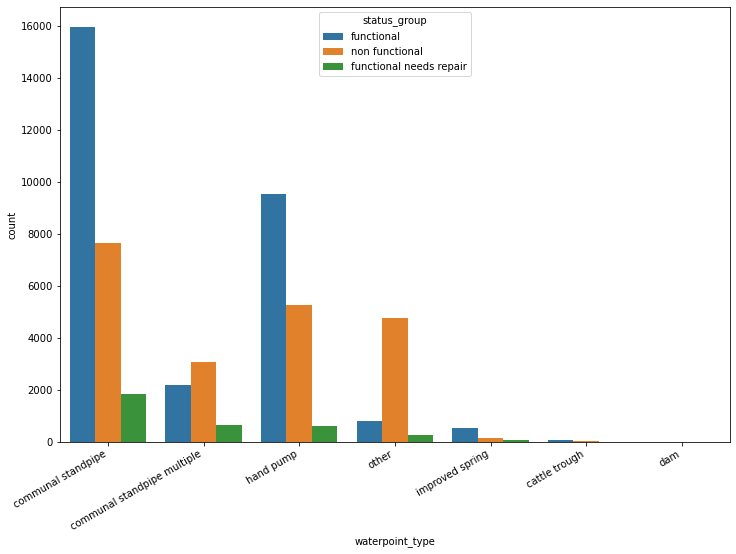

In [57]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='waterpoint_type', hue='status_group', data=df)
plt.xticks(rotation=30, ha='right');

Other and communal standpipe multiple have the highest rate of being non functioning.

#### Installer

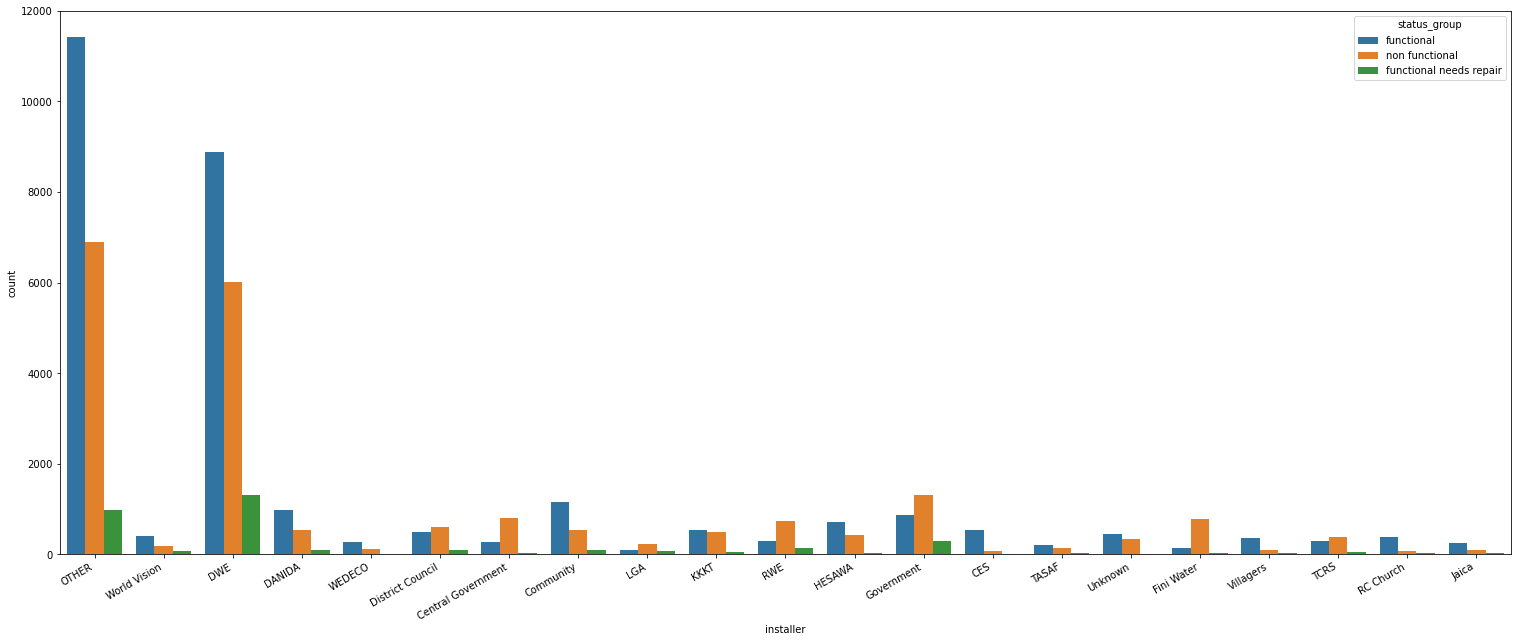

In [67]:
plt.figure(figsize=(26,10))
ax = sns.countplot(x='installer', hue='status_group', data=df)
plt.xticks(rotation=30, ha='right')
plt.save_fig('./images/installer_function.png');

The government, Fini Water, RWE, and Distict Council have a high rate of non functioning wells.  Other is out largest category.

### Well Function map

In [68]:
import folium

In [69]:
# Create 3 dataframes for each status_group
df_f = df[df['status_group'] == 'functional']
df_nf = df[df['status_group'] == 'non functional']
df_fnr = df[df['status_group'] == 'functional needs repair']

In [70]:
# Create lists of latitude and longitude values
lat_f = [x for x in df_f['latitude']]
long_f = [x for x in df_f['longitude']]

lat_nf = [x for x in df_nf['latitude']]
long_nf = [x for x in df_nf['longitude']]

lat_fnr = [x for x in df_fnr['latitude']]
long_fnr = [x for x in df_fnr['longitude']]

lat_long_f = [(lat_f[i], long_f[i]) for i in range(len(lat_f))]
lat_long_nf = [(lat_nf[i], long_nf[i]) for i in range(len(lat_nf))]
lat_long_fnr = [(lat_fnr[i], long_fnr[i]) for i in range(len(lat_fnr))]

In [71]:
#Create map
this_map = folium.Map()

# Loop through 3 dataframes and plot point for each coordinate
for coord in lat_long_nf[::5]:
    folium.CircleMarker(location=[coord[0], coord[1]], opacity=0.6, color='red', radius=1).add_to(this_map)
for coord in lat_long_f[::5]:
    folium.CircleMarker(location=[coord[0], coord[1]], opacity=0.6, color='green', radius=1).add_to(this_map)
for coord in lat_long_fnr[::5]:
    folium.CircleMarker(location=[coord[0], coord[1]], opacity=0.6, color='blue', radius=1).add_to(this_map) 

    
#Set the zoom to fit our bounds
this_map.fit_bounds(this_map.get_bounds())

#Save the map to a png file
this_map.save('./images/map_function.png')

this_map

As we saw above, there is a high rate of non functional waterpoints in the southeast corner of Tanzania in Mtwara and Lindi, as well as up north in Mara, and the southwest in Rukwa. We can see the cluster of high functional wells in Iringa, Shinyanga, Kilimanjaro, and Arusha.  There is a cluster of functional but need repair waterpoints in Kigoma.

### Change status_group  to integer format

In [72]:
# Change status_group/target values to numeric values
df['status'] = df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})
df.head()

status_group  amount_tsh  gps_height     installer  longitude   latitude  \
0      functional      6000.0        1390         OTHER  34.938093  -9.856322   
1      functional         0.0        1399         OTHER  34.698766  -2.147466   
2      functional        25.0         686  World Vision  37.460664  -3.821329   
3  non functional         0.0         263         OTHER  38.486161 -11.155298   
4      functional         0.0           0         OTHER  31.130847  -1.825359   

                     basin   region  population  permit  construction_year  \
0               Lake Nyasa   Iringa         109       0               1999   
1            Lake Victoria     Mara         280       1               2010   
2                  Pangani  Manyara         250       1               2009   
3  Ruvuma / Southern Coast   Mtwara          58       1               1986   
4            Lake Victoria   Kagera           0       1               1996   

  extraction_type_class management payment_type water_quality      quantity  \
0               gravity        vwc     annually          soft        enough   
1               gravity        wug    never pay          soft  insufficient   
2               gravity        vwc   per bucket          soft        enough   
3           submersible        vwc    never pay          soft           dry   
4               gravity      other    never pay          soft      seasonal   

            source_type              waterpoint_type  status  
0                spring           communal standpipe       2  
1  rainwater harvesting           communal standpipe       2  
2                   dam  communal standpipe multiple       2  
3              borehole  communal standpipe multiple       0  
4  rainwater harvesting           communal standpipe       2

In [73]:
df = df.drop('status_group', axis=1)

In [74]:
df.shape

(53309, 18)

## Modeling

### Data Preprocessing

Following we will create our dummy variables for our categorical columns and perform train test split to prepare for modeling.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53309 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53309 non-null  float64
 1   gps_height             53309 non-null  int64  
 2   installer              53309 non-null  object 
 3   longitude              53309 non-null  float64
 4   latitude               53309 non-null  float64
 5   basin                  53309 non-null  object 
 6   region                 53309 non-null  object 
 7   population             53309 non-null  int64  
 8   permit                 53309 non-null  int64  
 9   construction_year      53309 non-null  int64  
 10  extraction_type_class  53309 non-null  object 
 11  management             53309 non-null  object 
 12  payment_type           53309 non-null  object 
 13  water_quality          53309 non-null  object 
 14  quantity               53309 non-null  object 
 15  so

#### Create dummies

In [76]:
# Create lists of categorical and continuous columns
cat_col = ['installer','basin','region','extraction_type_class','management','payment_type','water_quality',
           'quantity','source_type','waterpoint_type']
cont_col = ['amount_tsh','gps_height','longitude','latitude','population','permit','construction_year']

In [79]:
#Create dummies
dummy_df = pd.get_dummies(df,columns=cat_col,drop_first=True)

dummy_df.shape

(53309, 102)

#### Separate target and perform train test split

In [80]:
y = dummy_df['status']
X = dummy_df.drop(['status'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Statistics Function

Accuracy will be our main metric used to track model performance, but we will calculate recall, precision, cross validation, and f1 score to provide more detail.

In [81]:
# function to track model metrics and plot confusion matrix

def model_score(model, X, y_pred, y_true):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted')
    cross = cross_val_score(estimator=model, X=X, y=y_true, cv=10).mean()
    
    print(f' The accuracy score is: {round(acc, 4)}')
    print(f' The recall score is: {round(rec, 4)}')
    print(f' The F1 score is: {round(f1, 4)}')
    print(f' The precision score is: {round(prec, 4)}')
    print(f' The cross validation score of accuracy is: {round(cross, 4)}')

    #Confusion matrix    
    return plot_confusion_matrix(model, X, y_true);

### Dummy Classifier Model

0.4583567810917276


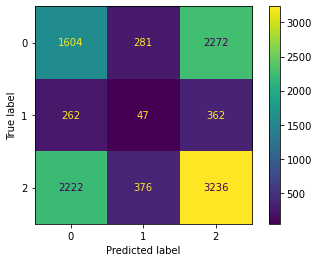

In [82]:
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)
print(dummy.score(X_test, y_test))

plot_confusion_matrix(dummy, X_test, y_test);

Our baseline dummy model performed very poorly with an accuracy score of 46%.  Our data is heavily imbalanced, which explains how our ternary model performed close to 50%.

### Logistic Regression

Test data model score:
 The accuracy score is: 0.7504
 The recall score is: 0.7504
 The F1 score is: 0.7275
 The precision score is: 0.7384
 The cross validation score of accuracy is: 0.7491


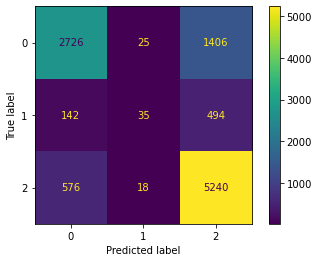

In [83]:
# Make pipe
pipe_lr = Pipeline([('ss', StandardScaler()), 
                    ('lr', LogisticRegression())])
# Fit and predict
pipe_lr.fit(X_train, y_train)
test_preds = pipe_lr.predict(X_test)

print("Test data model score:")
lr_score = model_score(pipe_lr, X_test, test_preds, y_test)

Our logistic regression model is improved to 75% accuracy over the dummy model.  This model struggled to predict wells that were functional but needed repairs, likely due to class imbalances.

### K Nearest Neighbors

Below I will run GridSearch with my Pipeline to create a K Nearest Neighbors model.  I ran GridSearch to find the best parameters, and have then commented out the code to save computing time while still showing the process.  The same process is repeated for all following models of running GridSearch and commenting out code.

In [73]:
# GridSearch 
knn = KNeighborsClassifier()
grid = {
    'n_neighbors' : [5, 10, 15, 20, 25, 40]
}

#knn_grid_search = GridSearchCV(knn, grid, cv=3)
#knn_grid_search.fit(X_train, y_train)

#knn_grid_search.best_params_

In [74]:
# Narrow down parameters for 2nd gridsearch
knn = KNeighborsClassifier()
grid = {
    'n_neighbors' : [7, 8, 9, 10, 11, 12, 13]
}

#knn_grid_search = GridSearchCV(knn, grid, cv=3)
#knn_grid_search.fit(X_train, y_train)

#knn_grid_search.best_params_

Test data model score:
 The accuracy score is: 0.7603
 The recall score is: 0.7603
 The F1 score is: 0.7512
 The precision score is: 0.7493
 The cross validation score of accuracy is: 0.7136


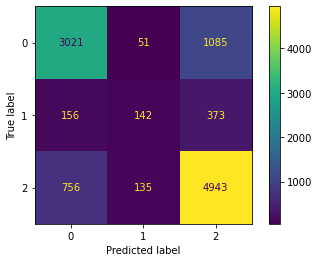

In [84]:
# Make pipe
pipe_knn = Pipeline([('ss', StandardScaler()), 
                    ('knn', KNeighborsClassifier(n_neighbors=9))])
#Fit and predict
pipe_knn.fit(X_train, y_train)
test_preds = pipe_knn.predict(X_test)

print("Test data model score:")
knn_score = model_score(pipe_knn, X_test, test_preds, y_test)

In [85]:
# Check for training and test sets
# Predict on training and test sets
training_preds = pipe_knn.predict(X_train)
test_preds = pipe_knn.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 80.23%
Validation accuracy: 76.03%


The K Nearest Neighbors model outperformed the Logistic Regression model.  Number of neighbors was hypertuned by running and GridSearch and optimal parameters were put into our pipe.  Our K Nearest Neighbors model is not overfitting as the accuracy of training and test sets are 80.23% and 76.03%, respectively.

### Decision Tree Classifier

In [77]:
# GridSearch commented out to show process
dt = DecisionTreeClassifier()
dt_grid = {
    'criterion' : ['entropy', 'gini'],
    'max_depth': [10, 20, 30, 40, 50, 60, None],
    'min_samples_split' : [1, 2, 5, 10, 20, 30],
    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5],
}

#dt_tree = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=5)
#dt_tree.fit(X_train, y_train)

#print(f'Best parameters are {dt_tree.best_params_}')
#print(f'Best score {dt_tree.best_score_}')  #0.768565112
#print(f'Best estimator score {dt_tree.best_estimator_.score(X_test, y_test)}')  #0.779309697

Test data model score:
 The accuracy score is: 0.7792
 The recall score is: 0.7792
 The F1 score is: 0.7741
 The precision score is: 0.7719
 The cross validation score of accuracy is: 0.7394


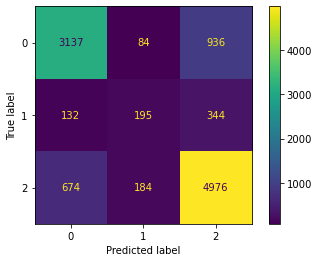

In [86]:
# Make pipe
pipe_dt = Pipeline([('ss', StandardScaler()), 
                    ('dt', DecisionTreeClassifier(criterion='gini', max_depth=20, min_impurity_split=0.2, 
                                                  min_samples_split=2))])
#Fit and Predict
pipe_dt.fit(X_train, y_train)
test_preds = pipe_dt.predict(X_test)

print("Test data model score:")
dt_score = model_score(pipe_dt, X_test, test_preds, y_test)

In [87]:
# Predict on training and test sets
training_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 89.29%
Validation accuracy: 77.92%


Our decision tree model once again improved our test accuracy scores to 78%, but the model is highly overfitting with training accuracy at 89%.

#### Function to plot feature importances

In [88]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,25))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

#### Decision Tree Feature Importances

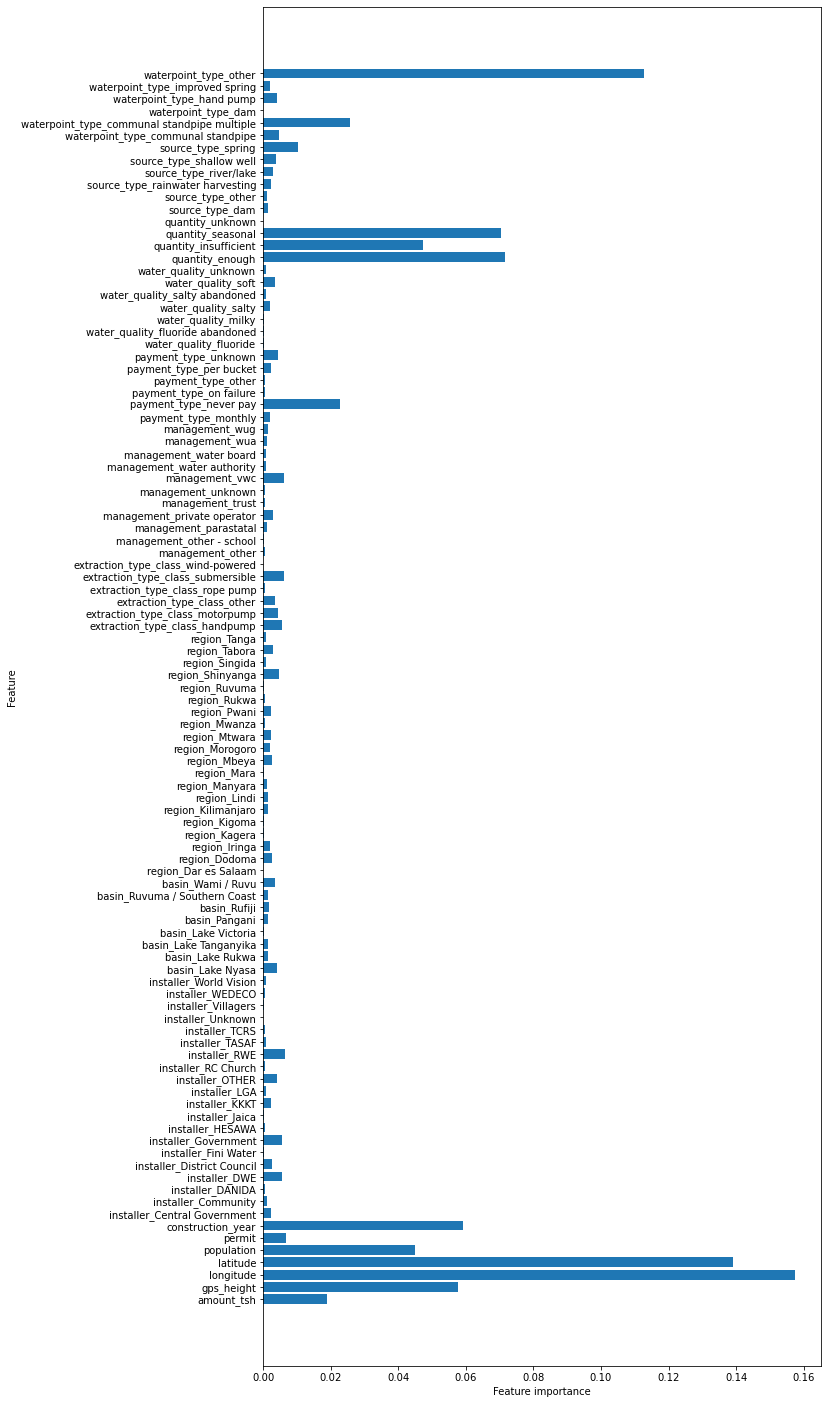

In [89]:
# Instantiate and fit a DecisionTreeClassifier with optimal parameters
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=20, min_impurity_split=0.2, min_samples_split=2) 
tree_clf.fit(X_train, y_train)

plot_feature_importances(tree_clf)

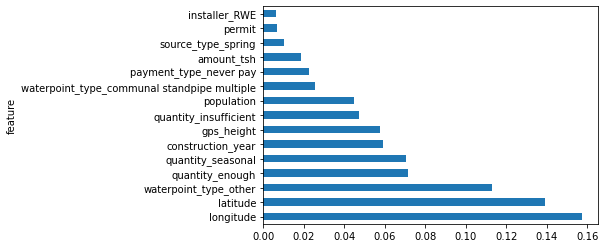

In [90]:
# Top features
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=tree_clf.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

Our decision tree model showed longitude, latitude, waterpoint type other, and enough quantity being the most important features.

### Random Forests

In [92]:
#Instantiate RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

#scores on folds
scores = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=5)
print(np.mean(scores))

#scores on on test
score = forest.score(X_test, y_test)
print(score)

# grid search on random forest

#grid = {
#    'criterion' : ['entropy', 'gini'],
#    'max_depth': [5,10,15,20, None],
#    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5], #values selected based on gini   
#    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5], #values selected based on gini
#}
#gs_forest = GridSearchCV(estimator=forest, param_grid=grid, cv=5)
#gs_forest.fit(X_train, y_train)

#print(f'Best parameters are {gs_forest.best_params_}')
#print(f'Best score {gs_forest.best_score_}')
#print(f'Best estimator score {gs_forest.best_estimator_.score(X_test, y_test)}')

0.6960396836556665
0.7069030200712811


Test data model score:
 The accuracy score is: 0.8094
 The recall score is: 0.8094
 The F1 score is: 0.7989
 The precision score is: 0.8028
 The cross validation score of accuracy is: 0.78


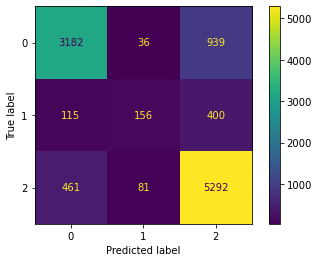

In [93]:
# Make pipeline with tuned hyperparameters
pipe_rf = Pipeline([('ss', StandardScaler()), 
                    ('RF', RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=20, min_impurity_split=0.1))])
# Fit and predict
pipe_rf.fit(X_train, y_train)
test_preds = pipe_rf.predict(X_test)

# Print metrics
print("Test data model score:")
rf_score = model_score(pipe_rf, X_test, test_preds, y_test)

In [94]:
# Predict on training and test sets
training_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 93.09%
Validation accuracy: 80.94%


Upon running GridSearch with our Random Forests Pipeline, we have once again improved from our baseline accuracy to 81.34% testing accuracy.  The model is still overfitting the training data, as the training accuracy is 93.19%, but this is our best performing model so far.

#### Random Forests Feature Importances

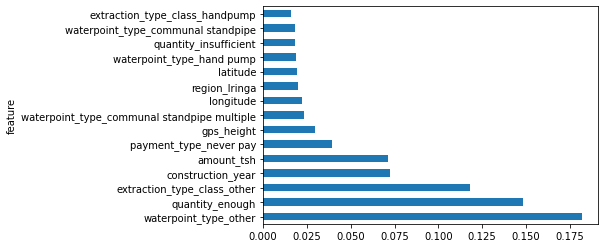

In [96]:
# Top features
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=forest.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

Our random forests model show waterpoint_type other, enough quantity, extraction_type_class_other, and construction_year being the most important features to the model. 

### XG Boost

Test data model score:
 The accuracy score is: 0.8094
 The recall score is: 0.8094
 The F1 score is: 0.7989
 The precision score is: 0.8028
 The cross validation score of accuracy is: 0.7808


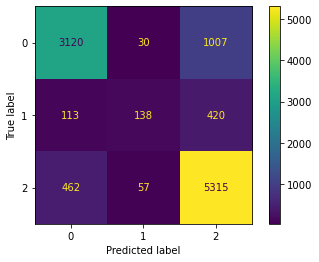

In [97]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train, y_train)

print("Test data model score:")
xgb_model_score = model_score(xgb, X_test, test_preds, y_test)

In [87]:
# Gridsearch commented out
xgb = XGBClassifier()
grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100, 250, 500],
}

#gs_xgb = GridSearchCV(estimator=xgb, param_grid=grid, cv=5)
#gs_xgb.fit(X_train, y_train)

#print(f'Best parameters are {gs_xgb.best_params_}')
#print(f'Best score {gs_xgb.best_score_}')  
#print(f'Best estimator score {gs_xgb.best_estimator_.score(X_test, y_test)}')  

Test data model score:
 The accuracy score is: 0.8178
 The recall score is: 0.8178
 The F1 score is: 0.8091
 The precision score is: 0.8122
 The cross validation score of accuracy is: 0.7817


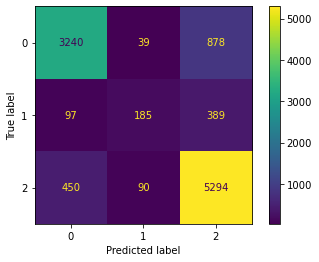

In [98]:
# Instantiate xg Boost Classifier with tuned hyperparameters
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=2,
                   n_estimators=250, subsample=0.7)
xgb.fit(X_train, y_train)
test_preds = xgb.predict(X_test)

print("Test data model score:")
dt_score = model_score(xgb, X_test, test_preds, y_test)

In [89]:
# Predict on training and test sets
training_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 92.5%
Validation accuracy: 81.78%


Our best performing model ended up being the XG Boost model with tuned hyperparameters, although the random forests model was not far behind with 80.94% testing accuracy.  The model has overfitted the training data, but the testing accuracy is overperforming any other model at 81.78%.

#### XGB Feature Importances 

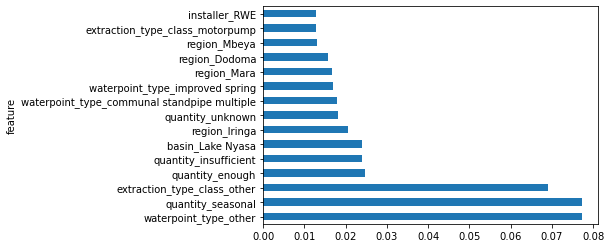

In [91]:
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=xgb.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

Our XG Boost model shows the most important features to be waterpoint_type_other, quantity_seasonal, extraction_type_class_other, and quantity_enough.

#### SMOTE and XGBoost

In [99]:
# Apply SMOTE oversampling 

oversample = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train_smote.value_counts())

2    23192
0    16672
1     2783
Name: status, dtype: int64
2    23192
1    23192
0    23192
Name: status, dtype: int64


Test data model score:
 The accuracy score is: 0.798
 The recall score is: 0.798
 The F1 score is: 0.7991
 The precision score is: 0.8015
 The cross validation score of accuracy is: 0.7817


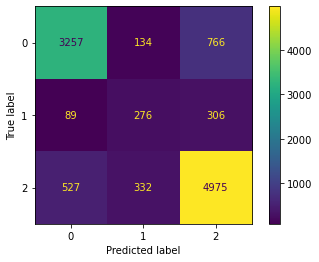

In [100]:
# Instatiate XGB with SMOTE preprocessing
xgb_smote = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=2,
                   n_estimators=250, subsample=0.7)
xgb_smote.fit(X_train_smote, y_train_smote)
test_preds = xgb_smote.predict(X_test)

print("Test data model score:")
dt_score = model_score(xgb_smote, X_test, test_preds, y_test)

In [94]:
# Predict on training and test sets
training_preds = xgb_smote.predict(X_train)
test_preds = xgb_smote.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 91.63%
Validation accuracy: 79.65%


Our XG Boost model with SMOTE prepreprocessing gave us worse accuracy and more overfitting that the non SMOTE XG Boost model.  The XG Boost model is our final model, yeilding 81.78% accuracy on test data.

### ROC AUC Analysis

In [101]:
# Binarize for multiclass problem
y_multi_test = label_binarize(y_test, classes=[0, 1, 2])

# Predict probability for each model
dt_model_pred_proba = pipe_dt.predict_proba(X_test)
rf_model_pred_proba = pipe_rf.predict_proba(X_test)
knn_model_pred_proba = pipe_knn.predict_proba(X_test)
log_model_pred_proba = pipe_lr.predict_proba(X_test)
dummy_model_pred_proba = dummy.predict_proba(X_test)
xgb_model_pred_proba = xgb.predict_proba(X_test)

# Calculate AUC ROC score using predicted probablity for each model
dt_test = roc_auc_score(y_multi_test, dt_model_pred_proba, multi_class='ovr')
rf_auc = roc_auc_score(y_multi_test, rf_model_pred_proba, multi_class='ovr')
knn_auc = roc_auc_score(y_multi_test, knn_model_pred_proba, multi_class='ovr')
log_model_auc = roc_auc_score(y_multi_test, log_model_pred_proba, multi_class='ovr')
dummy_auc = roc_auc_score(y_multi_test, dummy_model_pred_proba, multi_class='ovr')
xgb_auc = roc_auc_score(y_multi_test, xgb_model_pred_proba, multi_class='ovr')

print(f'The AUC score for our baseline model is: {round(dummy_auc, 4)}')
print(f'The AUC score for our decision tree model is: {round(dt_test, 4)}')
print(f'The AUC score for our random forest model is: {round(rf_auc, 4)}')
print(f'The AUC score for our k nearest neighbor model is: {round(knn_auc, 4)}')      
print(f'The AUC score for our logistic regression model is: {round(log_model_auc, 4)}')
print(f'The AUC score for our XG Boost model is: {round(xgb_auc, 4)}')

The AUC score for our baseline model is: 0.5029
The AUC score for our decision tree model is: 0.7685
The AUC score for our random forest model is: 0.899
The AUC score for our k nearest neighbor model is: 0.8503
The AUC score for our logistic regression model is: 0.8315
The AUC score for our XG Boost model is: 0.9045


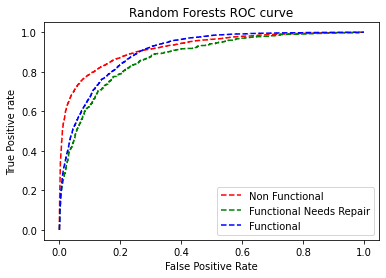

In [96]:
fig, ax = plt.subplots()

# Create dictionary
n_class = 3

fpr = {}
tpr = {}
thresh ={}

# Iterate through each class to create roc_curve
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, rf_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Non Functional')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Functional Needs Repair')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Functional')
plt.title('Random Forests ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best'); 

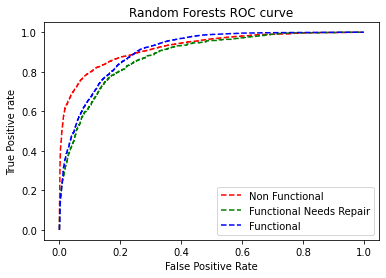

In [97]:
# Iterate through each class to create roc_curve
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, xgb_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Non Functional')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Functional Needs Repair')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Functional')
plt.title('XG Boost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best'); 

Before performing the ROC AUC curves analysis, our best performing model was our XG Boost model, followed closely by our Random Forest model.  The AUC of each model showed the same results again with XG Boost (AUC = 90.45%) outperforming all other models, followed closely by our Random Forests (AUC = 89.9%) model. 

## Conclusions

XG Boost was our top performing model, although Random Forests was not far behind.  The poor performance of the K Nearest Neighbors, Decision Tree, and Logistic Regression models indicate that the data is not easily separable.  Our XG Boost model performs with an 81.78% testing accuracy.  The XG Boost model also boasted the highest AUC scores at 90.45%.

Based on my findings, I am confident to partner with the Tanzanian government to help solve their water crisis by predicting water pump failure. As we illustrated above, there is a high rate of non functional waterpoints in the southeast corner of Tanzania in Mtwara and Lindi, as well as up north in Mara, and the southwest in Rukwa. These areas need immediate attention as the situations here are critical.  There are a high number of functional wells in Iringa, Shinyanga, Kilimanjaro, and Arusha. There is a cluster of functional but need repair waterpoints in Kigoma, these should be addressed to prevent failure which can be more expensive to repair. Several of our models showed one of it's most important features to be quantity enough for the waterpoint.  There are over 8,000 waterpoints that have enough water in them but are non functional.  These are a high priority to address as well since there is water present.
